# Path Planning using the Visibility Graph Method

This is one of the road map approaches, based on the observation that the shortest path will just scrape the corners of the obstacles.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from random import random
from math import atan2,sqrt,sin,cos

Define a start point, a goal point, and some obstacles represented as polygons.  Then plot the world, including a handy utility for plotting closed polygons.

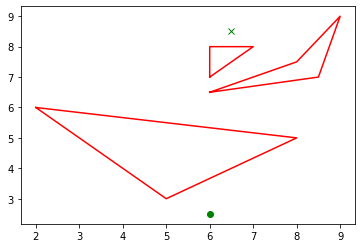

In [2]:
obstacles = [np.array([[2.,6.],[8.,5.],[5.,3.]]),np.array([[6.,6.5],[8.5,7.],[9.,9.],[8.,7.5]]),np.array([[6,7],[7,8],[6,8]])]
start = [6.,2.5,np.pi/4.]
goal = [6.5,8.5]

def plot_poly(points,fmt='b-',**kwargs):
    plt.plot(np.append(points[:,0],points[0,0]),np.append(points[:,1],points[0,1]),fmt)

for ob in obstacles:
    plot_poly(ob,'r-')

plt.plot(start[0],start[1],'go',goal[0],goal[1],'gx')
plt.show()

Plot the line between all pairs of vertices, including the start and goal.  This will be a mess, but it's our starting point.

> For a large number of obstacles, any 'all pairs' operation will be a big computation.  Luckily we don't have much do with each.

Notice that I'm putting all the nodes into the one `all_points` list, with the goal as the first entry and the start point as the second.  We'll need that information later when we reconstruct the path.

In [3]:
tree = np.array([start])
tree = np.append(tree,[start],0)
#tree = np.append(tree,[start],0)
delta = 0.2
del_hdg = 0.2
print(tree)

[[6.         2.5        0.78539816]
 [6.         2.5        0.78539816]]


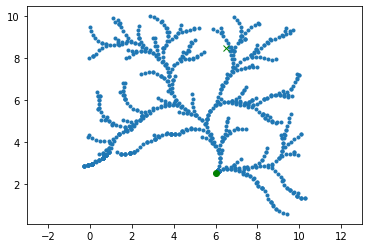

In [4]:
for ii in range(1000):
    r = 10.0*np.array([random(),random()])
    #print(r)
    dx = tree[:,0]-r[0]
    dxx = dx**2
    dy = tree[:,1]-r[1]
    dyy = dy**2
    dsq = dxx+dyy
    #print(dsq)
    nn = np.argmin(dsq)
    #print(nn)
    #print(tree[nn,0],tree[nn,1])
    hdg = atan2(r[0]-tree[nn,0],r[1]-tree[nn,1])
    #print(hdg*180/np.pi)
    if hdg<tree[nn,2]-del_hdg:
        hdg=tree[nn,2]-del_hdg
    elif hdg>tree[nn,2]+del_hdg:
        hdg=tree[nn,2]+del_hdg
    n = np.array([tree[nn,0]+delta*sin(hdg),tree[nn,1]+delta*cos(hdg),hdg])
    tree = np.append(tree,[n],0)
    #print(tree)
    
#plt.plot([r[0],tree[nn,0]],[r[1],tree[nn,1]],'mx:')
#plt.plot(n[0],n[1],'go')
plt.plot(tree[:,0],tree[:,1],'.')
plt.plot(start[0],start[1],'go',goal[0],goal[1],'gx')
plt.axis('equal')
plt.show()

In [5]:
def lines_cross(a,b,c,d):
    M = np.array([[b[0]-a[0],c[0]-d[0]],[b[1]-a[1],c[1]-d[1]]])
    if np.linalg.det(M)==0.:
        return(False)
    v = np.array([[c[0]-a[0]],[c[1]-a[1]]])
    w = np.linalg.solve(M,v)
    if w[0]<=0:
        return(False)
    elif w[0]>=1:
        return(False)
    elif w[1]<=0:
        return(False)
    elif w[1]>=1:
        return(False)
    else:
        return(True)
    
def line_crosses_obst(a,b,obst):
    for ii in range(len(obst)):
        if lines_cross(a,b,obst[ii-1],obst[ii]):
            return(True)
    # extra test in case line is completely inside
    num_crosses = 0
    for ii in range(len(obst)):
        if lines_cross(0.5*(a+b),[max(obst[:,0])+0.01,max(obst[:,1])+0.01],obst[ii-1],obst[ii]):
            num_crosses = num_crosses+1
    if num_crosses%2==1:
        return(True)
    return(False)
            
def is_visible(a,b,obstacles):
    for ob in obstacles:
        if line_crosses_obst(a,b,ob):
            return(False)
    return(True)